# Introduction

In this project we will analyze a dataset that contains information about a credit card company’s clients. We will help the company segment customers into different groups in order to apply different business strategies for each type of customer. The ML algorithm we'll use is k-means cluster.

Import the libraries and the data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
sns.set_style('whitegrid')
%matplotlib inline
np.random.seed(42)

cust = pd.read_csv('customer_segmentation.csv')

Print some basic summary stats on our dataframe

In [2]:
cust.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
cust.shape

(10127, 14)

In [4]:
cust.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [5]:
cust.isna().sum().sum()

0

Next, we'll plot histograms for all the numeric fields

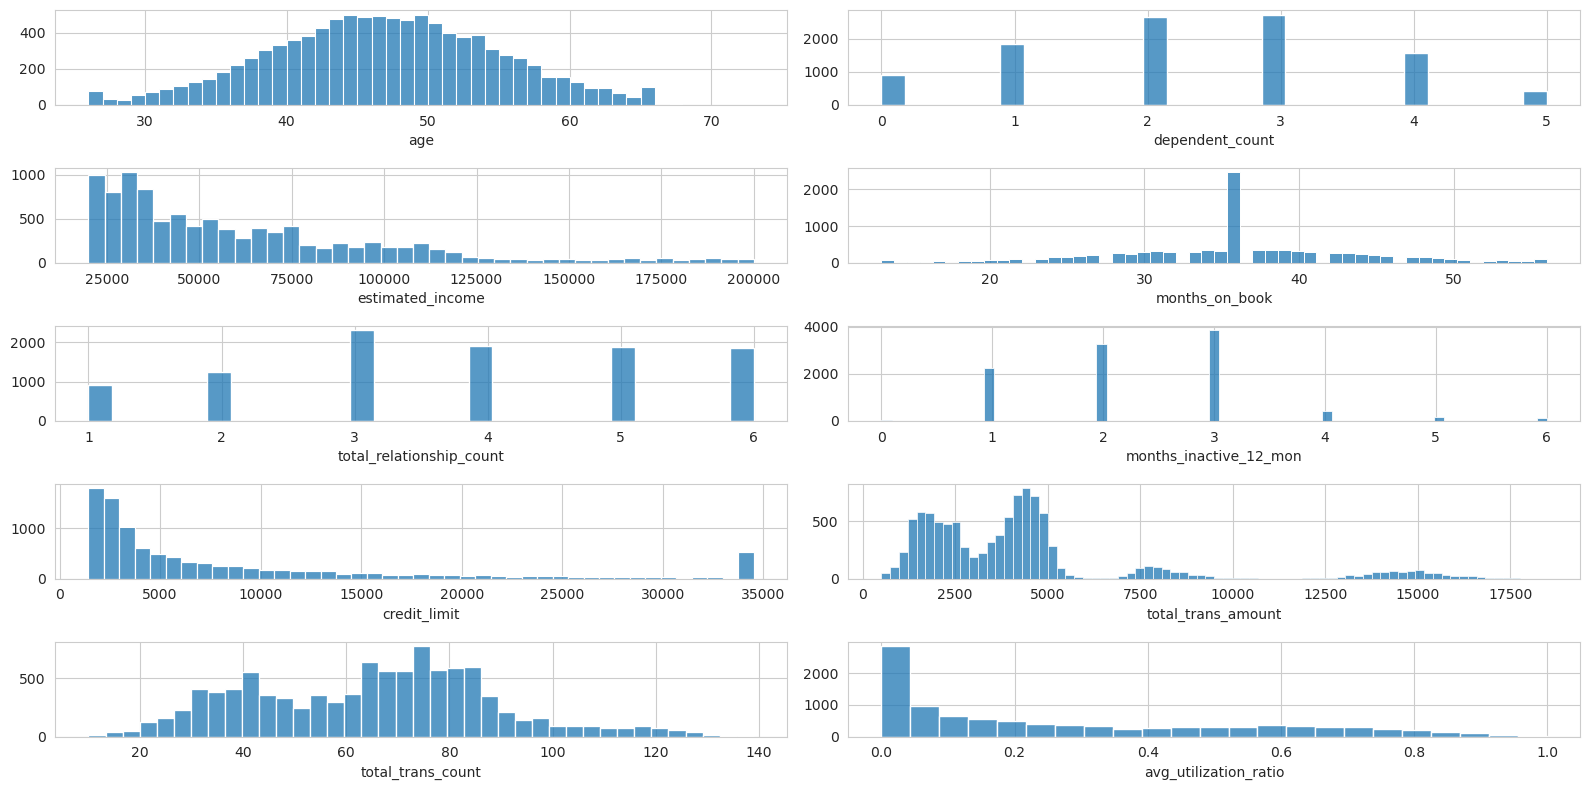

In [6]:
cust_numeric = cust.select_dtypes(include=np.number).drop(columns='customer_id')
fig, axs = plt.subplots(cust_numeric.shape[1]//2, 2, figsize=(16, 8))

for i, c in enumerate(cust_numeric.columns):
    g = sns.histplot(data=cust_numeric[c], ax=axs[i//2][i%2])
    g.set_ylabel('')

plt.tight_layout()
plt.show()

Some observations: Income is right-skewed, as we might expect. The credit limit might have a truncation issue around $34,000. The total transaction amounts seem to have four peaks. Most of these distributions are not normal.

Feature Engineering
========

In [7]:
cust_raw = cust.copy()

Categorical Variables
------------

In [8]:
cust.select_dtypes(include=object).columns

Index(['gender', 'education_level', 'marital_status'], dtype='object')

Gender can be converted to a 1/0 binary variable.

In [9]:
cust['gender'] = cust['gender'].map({'M': 1, 'F': 0})
cust['gender']

0        1
1        0
2        1
3        0
4        1
        ..
10122    1
10123    1
10124    0
10125    1
10126    0
Name: gender, Length: 10127, dtype: int64

In [10]:
cust['education_level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Post-Graduate',
       'College', 'Doctorate'], dtype=object)

We'll map education levels to an ordinal variable that increases with more education

In [11]:
education_levels = {'Uneducated' : 0, 'High School' : 1, 'College' : 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5}
cust['education_level'] = cust['education_level'].map(education_levels)
cust['education_level']

0        1
1        3
2        3
3        1
4        0
        ..
10122    3
10123    3
10124    1
10125    3
10126    3
Name: education_level, Length: 10127, dtype: int64

In [12]:
cust['marital_status'].unique()

array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object)

We will one hot code marital status 

In [13]:
cust = pd.get_dummies(data = cust, columns = ['marital_status'])
cust.columns

Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'estimated_income', 'months_on_book', 'total_relationship_count',
       'months_inactive_12_mon', 'credit_limit', 'total_trans_amount',
       'total_trans_count', 'avg_utilization_ratio', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Unknown'],
      dtype='object')

Scale Variables
--------

In [14]:
X = cust.drop(columns='customer_id')

Now, we need to scale the data so that the k-means cluster algorithm works well. We'll use scikit-learn's standard scaler.

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.16540558,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867, ..., -0.92821381,
         1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       ...,
       [-0.29014957, -0.9434357 , -1.03646242, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [-2.03656544,  1.05995565, -0.26654715, ..., -0.92821381,
        -0.79850685,  3.53845931],
       [-0.41489356, -0.9434357 , -0.26654715, ...,  1.07733799,
        -0.79850685, -0.28260887]])

K Means Cluster Model
=============

Optimize Number of Clusters
-------------

The idea is to run a number of models and examine the "elbow plot" to find the optimal number of clusters.

In [16]:
inertias = []
for k in range(1,11):
    model = KMeans(n_clusters = k)
    model.fit_predict(X)
    inertias.append(model.inertia_)
    
inertias

[162031.99999999997,
 144649.74481322523,
 132111.91416515448,
 121165.14629203925,
 111788.4974635199,
 103874.10605979915,
 98669.28230272203,
 94563.63640526694,
 91184.86203776271,
 88892.8728944882]

Text(0.5, 1.0, 'Elbow Plot')

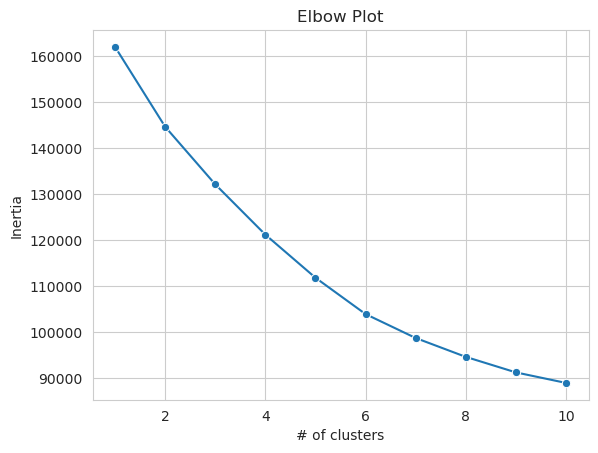

In [17]:
g = sns.lineplot(x=range(1,11), y=inertias, marker='o')
g.set_ylabel('Inertia')
g.set_xlabel('# of clusters')
g.set_title("Elbow Plot")

It looks like the optimal number of clusters is around 5 to 7. We'll try 6.

Fit Final Model
--------------

In [18]:
model = KMeans(n_clusters = 6)

Add a column in the `cust` dataframe that gives the cluster assignment number

In [20]:
cust_raw['cluster'] = model.fit_predict(X) + 1
cust['cluster'] = cust_raw['cluster']

In [21]:
cust['cluster'].value_counts().sort_index()

1    1641
2    2879
3     740
4    3261
5     739
6     867
Name: cluster, dtype: int64

Here, we'll examine the kernel density plots for some important numeric variables by cluster

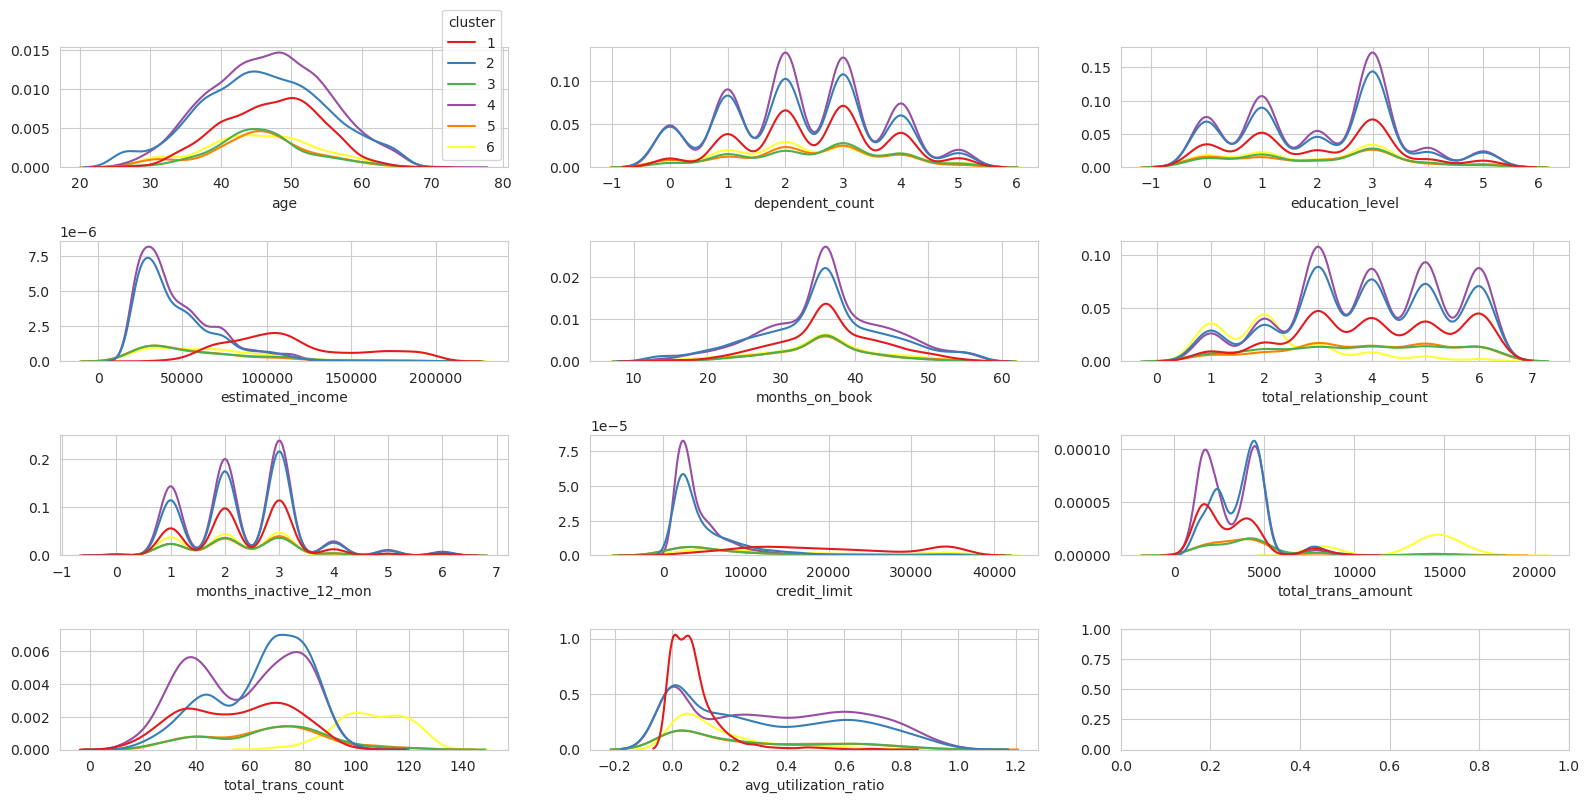

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(16, 8))

for i, c in enumerate(['age', 'dependent_count', 'education_level',
       'estimated_income', 'months_on_book', 'total_relationship_count',
       'months_inactive_12_mon', 'credit_limit', 'total_trans_amount',
       'total_trans_count', 'avg_utilization_ratio']):
    g = sns.kdeplot(data=cust, x=c, hue='cluster', palette='Set1', ax=axs[i//3][i%3], legend=True if i==0 else False)
    g.set_ylabel('')

plt.tight_layout()
plt.show()

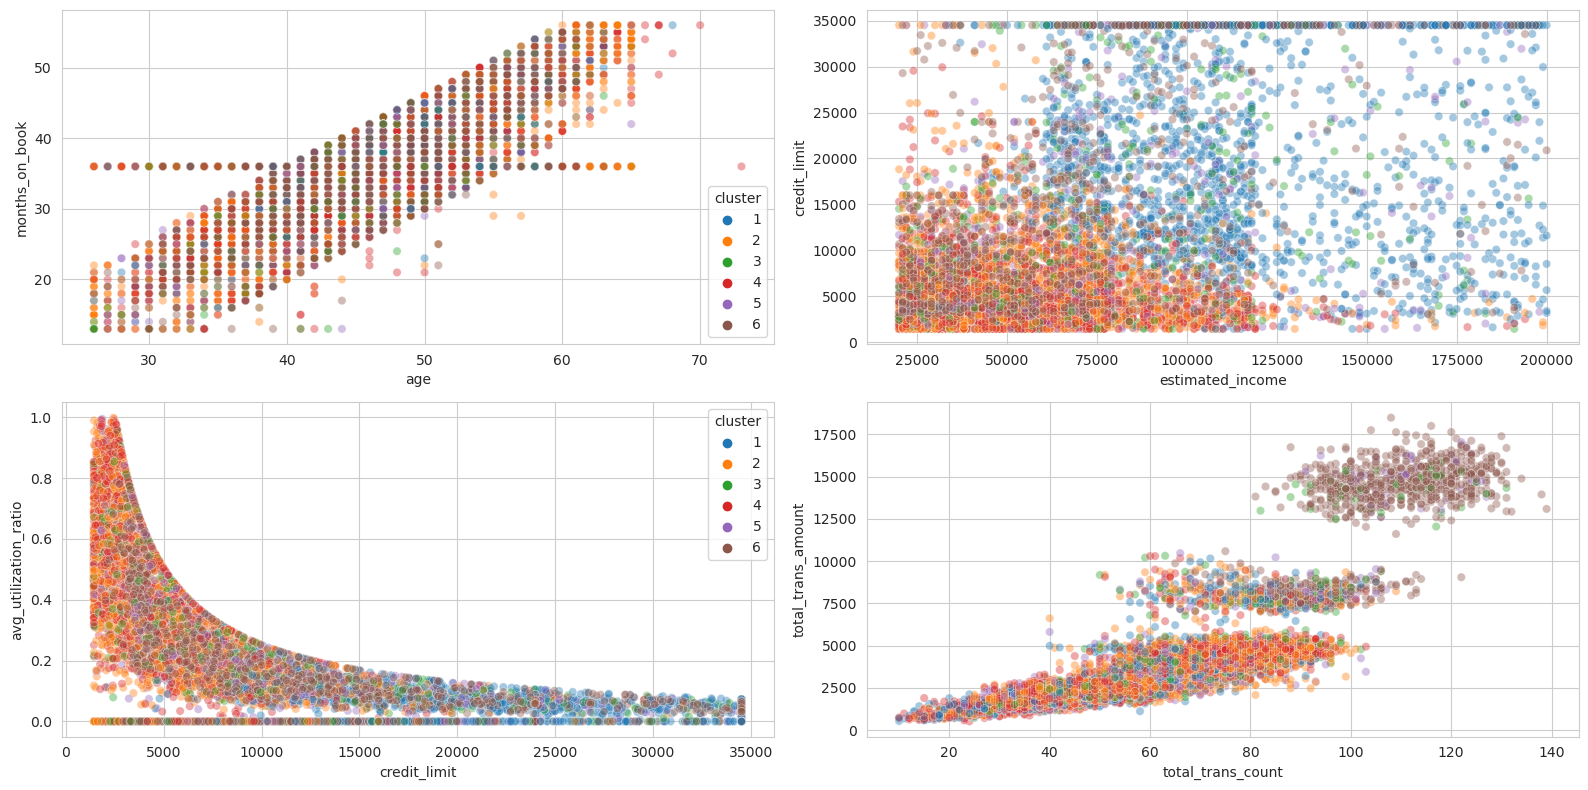

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='cluster', data=cust, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='cluster', data=cust, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='cluster', data=cust, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='cluster', data=cust, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

We can draw some conclusions about the clusters from these charts. For instance, Clusters 1 and 3 appear to have higher credit limit and incomes than the other clusters. Clusters 2 and 4 have low credit limits. Clusters 5 and 6 are the oldest. Members of Cluster 1 do not use the credit card a lot (despite their higher income).

Next, we look at the categorical variables by cluster

<AxesSubplot:xlabel='cluster'>

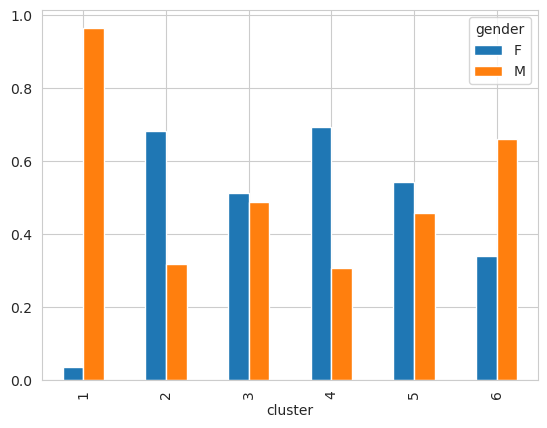

In [25]:
pd.crosstab(index=cust['cluster'], columns=cust_raw['gender'], normalize='index').plot.bar()

Gender is well-balanced across clusters, except Cluster 1 is much more likely to be male.

<AxesSubplot:xlabel='cluster'>

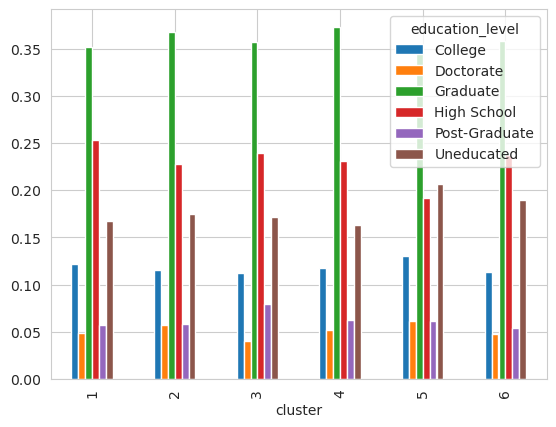

In [26]:
pd.crosstab(index=cust_raw['cluster'], columns=cust_raw['education_level'], normalize='index').plot.bar()

Education seems well distributed across the clusters.

<AxesSubplot:xlabel='cluster'>

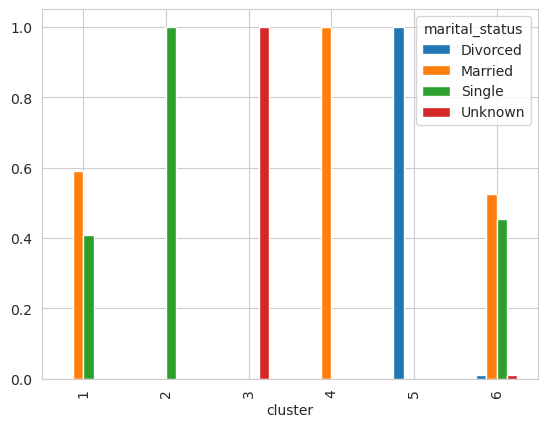

In [27]:
pd.crosstab(index=cust['cluster'], columns=cust_raw['marital_status'], normalize='index').plot.bar()

Cluster 2 is all single people, Cluster 3 is all unknown marital status, Cluster 4 is all married people, and Cluster 5 are all divorced. 

Conclusion
========

There are plenty of possible business insights to glean from the above analysis. For example, Cluster 1 is populated by both married and single people, most of whom are male, with high income and credit limits, but who do not use the credit card a lot. These people might be especially amenable to an advertizing campaign for products typically geared toward wealthier men that incentivizes greater use of the credit card.